In [1]:
import os
import torch
import torch.nn as nn
import torch.distributions as td
import numpy as np 
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

from flow.nvp_y import RealNVP

def convert(x):
    return torch.as_tensor(x).float()

In [2]:
# Data
data_dim = 2
parameter_dim = 2
# Model
H = 256 # Hidden size
L = 3 # Layers
# Optimisation
lr = 3e-4
n_steps = 5_000
batch_size = 400

In [3]:
net_s = lambda: nn.Sequential(
    nn.Linear(data_dim + parameter_dim, H), 
    nn.Tanh(),
    nn.Linear(H, H), 
    nn.Tanh(),
    nn.Linear(H, data_dim), 
    nn.Tanh()
)
net_t = lambda: nn.Sequential(
    nn.Linear(data_dim + parameter_dim, H), 
    nn.Tanh(), 
    nn.Linear(H, H), 
    nn.Tanh(), 
    nn.Linear(H, data_dim)
)

masks = convert(np.array([[0., 1.], [1., 0.]] * 3))

prior = td.MultivariateNormal(torch.zeros(data_dim), torch.eye(data_dim))

flow = RealNVP(net_s, net_t, masks, prior)

In [4]:
field_type = "LN"
data_dir = "data/"
X = np.load(os.path.join(data_dir, field_type + "_nn_summaries.npy"))
Y = np.load(os.path.join(data_dir, "field_parameters.npy"))

X_ = np.load(os.path.join(data_dir, field_type + "_nn_summary_data.npy"))

print(X.shape, Y.shape)

(20000, 2) (20000, 2)


In [5]:
def get_data(n):
    ix = np.random.randint(len(X), size=(n,))
    return convert(X[ix]), convert(Y[ix])

optimizer = torch.optim.Adam(flow.parameters(), lr=lr)

losses = []
with trange(n_steps) as steps:
    for s in steps:
        x, y = get_data(batch_size)

        loss = -flow.log_prob(x, y).mean()
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        losses.append(loss.item())
        steps.set_postfix(loss=f"{loss:.3E}")

  0%|          | 0/5000 [00:00<?, ?it/s]

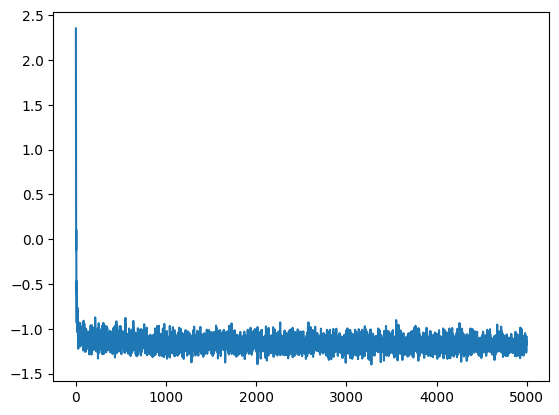

In [6]:
plt.figure()
plt.plot(losses)
plt.show()

(20000, 2)


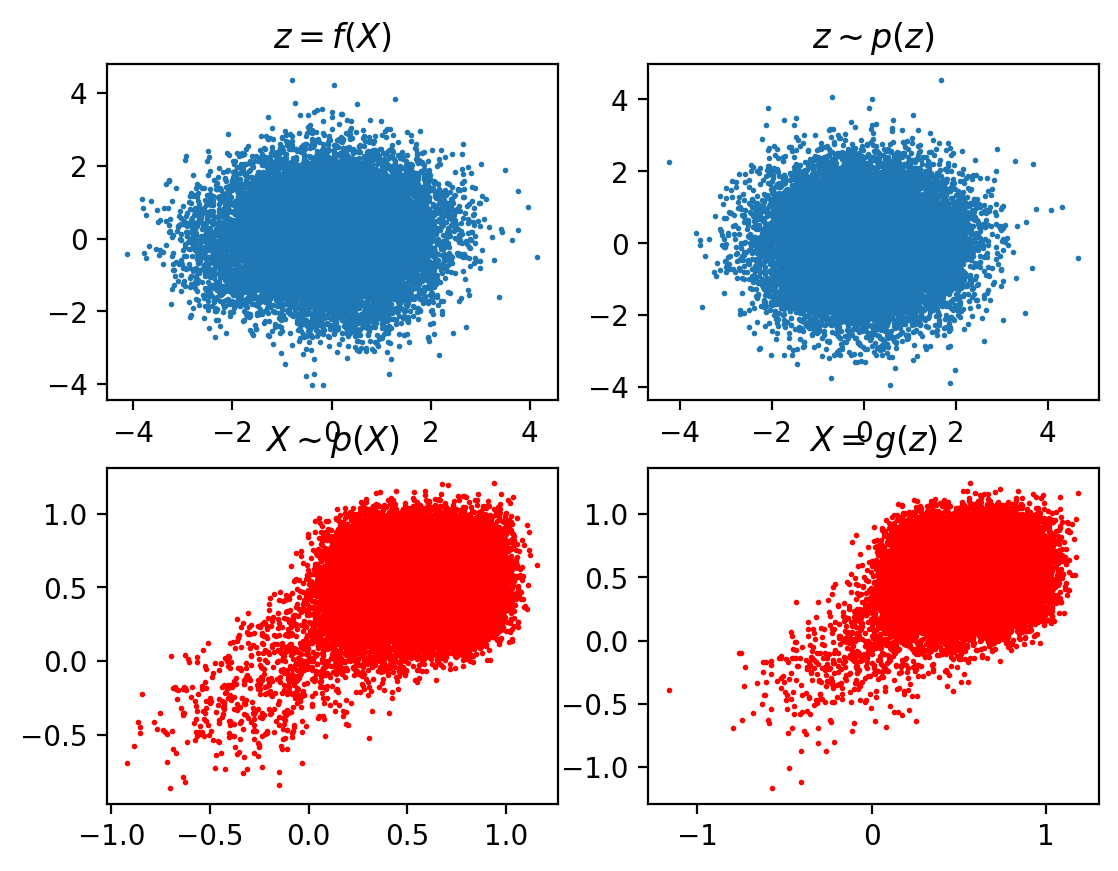

In [7]:
plt.figure(dpi=200)

z = flow.forward(convert(X), convert(Y))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1], s=1.)
plt.title(r'$z = f(X)$')

z = prior.sample((len(X),))
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1], s=1.)
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
plt.scatter(X[:, 0], X[:, 1], c='r', s=1.)
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(len(X), convert(Y)).detach().numpy()
print(x.shape)
plt.scatter(x[:, 0], x[:, 1], c='r', s=1.)
plt.title(r'$X = g(z)$')

plt.show()

In [8]:
def tile_like(x, y):
    return torch.tile(x, (len(y), 1))

def sample(log_prob, data, n_params, n_walkers, n_steps, walkers1, walkers2):

    # Progress-bar
    pbar = tqdm(total=n_steps, desc="Sampling")  # Jupyter notebook or qtconsole

    # Initialize current state
    current_state1 = torch.as_tensor(walkers1)
    current_state2 = torch.as_tensor(walkers2)

    # Initial target log prob for the walkers (and set any nans to -inf)...
    logp_current1 = log_prob(tile_like(data, current_state1), current_state1)
    logp_current2 = log_prob(tile_like(data, current_state2), current_state2)

    logp_current1 = torch.as_tensor(logp_current1)
    logp_current2 = torch.as_tensor(logp_current2)

    logp_current1 = torch.where(
        torch.isnan(logp_current1),
        torch.ones_like(logp_current1).fill_(float("inf")),
        logp_current1)
    logp_current2 = torch.where(
        torch.isnan(logp_current2),
        torch.ones_like(logp_current2).fill_(float("inf")),
        logp_current2)

    # Holder for the whole chain
    chain = [torch.cat([current_state1, current_state2], axis=0)]


    # MCMC loop
    for epoch in range(1, n_steps):

        # FIRST SET OF WALKERS:
        # Proposals
        idx1 = torch.randint(low=0, high=n_walkers, size=(n_walkers,))
        partners1 = current_state2[idx1]
        z1 = 0.5 * (torch.rand((n_walkers,)) + 1) ** 2
        proposed_state1 = partners1 + (z1 * (current_state1 - partners1).T).T

        # Target log prob at proposed points
        logp_proposed1 = log_prob(tile_like(data, proposed_state1), proposed_state1)
        logp_proposed1 = torch.as_tensor(logp_proposed1)
        logp_proposed1 = torch.where(
            torch.isnan(logp_proposed1),
            torch.ones_like(logp_proposed1).fill_(float("inf")),
            logp_proposed1)

        # Acceptance probability
        p_accept1 = torch.minimum(
            torch.ones(n_walkers),
            z1 ** (n_params - 1) * torch.exp(logp_proposed1 - logp_current1)
        )

        # Accept or not
        accept1_ = torch.rand((n_walkers,)) <= p_accept1
        accept1 = accept1_.type(torch.float32)

        # Update the state
        current_state1 = (
            (current_state1).T * (1 - accept1) + (proposed_state1).T * accept1
        ).T
        logp_current1 = torch.where(accept1_, logp_proposed1, logp_current1)

        # SECOND SET OF WALKERS:
        # Proposals
        #idx2 = torch.as_tensor(np.random.randint(0, n_walkers, n_walkers))
        idx2 = torch.randint(low=0, high=n_walkers, size=(n_walkers,))
        partners2 = current_state1[idx2]
        z2 = 0.5 * (torch.rand((n_walkers,)) + 1) ** 2
        proposed_state2 = partners2 + (z2 * (current_state2 - partners2).T).T

        # Target log prob at proposed points
        logp_proposed2 = log_prob(tile_like(data, proposed_state2), proposed_state2)
        logp_proposed2 = torch.as_tensor(logp_proposed2)
        logp_proposed2 = torch.where(
            torch.isnan(logp_proposed2),
            torch.ones_like(logp_proposed2).fill_(float("inf")),
            logp_proposed2)

        # Acceptance probability
        p_accept2 = torch.minimum(
            torch.ones(n_walkers),
            z2 ** (n_params - 1) * torch.exp(logp_proposed2 - logp_current2)
        )

        # Accept or not
        accept2_ = torch.rand((n_walkers,)) <= p_accept2
        accept2 = accept2_.type(torch.float32)

        # Update the state
        current_state2 = (
            (current_state2).T * (1 - accept2) + (proposed_state2).T * accept2
        ).T
        logp_current2 = torch.where(accept2_, logp_proposed2, logp_current2)

        # Append to chain
        chain.append(torch.cat([current_state1, current_state2], axis=0))

        # Update the progressbar
        pbar.update(1)

    # Stack up the chain
    chain = torch.stack(chain, axis=0)

    # Chain = np.unique(chain, axis=0) # this may need to be here,
    return chain[1:, :, :]

In [9]:
(400_000 - 4096 - 2) / (400_000 - 1)

0.989757474393686

In [10]:
alpha = np.load(os.path.join(data_dir, field_type + "_alpha.npy"))
derivatives = np.load(os.path.join(data_dir, field_type + "_derivatives.npy"))
covariance = np.load(os.path.join(data_dir, field_type + "_covariance.npy"))
precision = np.linalg.inv(covariance) # Assuming H ~ 1

# Is this right? Forecast assuming linear model and Gaussian errors
Finv = np.linalg.inv(np.linalg.multi_dot([derivatives, precision, derivatives.T]))

In [11]:
n_walkers = 500

walkers = td.MultivariateNormal(convert(alpha), convert(Finv)).sample((2 * n_walkers,))
walkers1, walkers2 = torch.chunk(walkers, 2, dim=0)

chain = sample(
    flow.log_prob,
    data=torch.as_tensor(X_).float()[None, :],
    n_params=parameter_dim,
    n_walkers=n_walkers,
    n_steps=400,
    walkers1=walkers1,
    walkers2=walkers2
).numpy()

Sampling:   0%|          | 0/400 [00:00<?, ?it/s]

ValueError: Expected value argument (Tensor of shape (500, 2)) to be within the support (IndependentConstraint(Real(), 1)) of the distribution MultivariateNormal(loc: torch.Size([2]), covariance_matrix: torch.Size([2, 2])), but found invalid values:
tensor([[ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-3.3791, -3.1362],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-3.3791, -3.1362],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.6256,  1.5151],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.7825, -1.8867],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8428, -1.5031],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [    nan,     nan],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-3.3791, -3.1362],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [ 1.7151,  1.5277],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8428, -1.5031],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8288, -1.8807],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-3.3791, -3.1362],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557],
        [ 1.7151,  1.6354],
        [-1.8379, -1.6557]], grad_fn=<AddBackward0>)

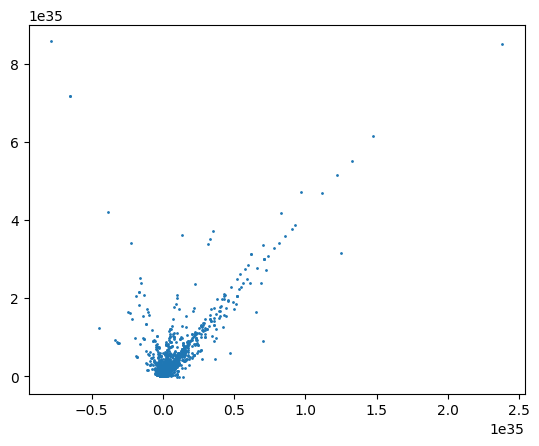

In [ ]:
plt.scatter(*chain[int(0.1 * len(chain)):].T, s=1.)
plt.show()